In [116]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from mpl_toolkits import mplot3d
from kneed import KneeLocator

In [117]:
covid_df = pd.read_csv('./data/covid_archive/country_wise_latest.csv');
h1n1_df = pd.read_csv('./h1n1_archive/data.csv');
city_country_relation = pd.read_csv('./quality_of_life_archive/cities.csv');
city_df = pd.read_csv('./quality_of_life_archive/movehubqualityoflife.csv');

In [118]:
city_2_country = city_country_relation.set_index('City').to_dict()
city_2_country = city_2_country['Country']
print(city_2_country)

{'Oakland': 'United States', 'Oakville': 'Canada', 'Oaxaca de Juárez': 'Mexico', 'Oberhausen': 'Germany', 'Obihiro': 'Japan', 'Obninsk': 'Russia', 'Oceanside': 'United States', 'Odawara': 'Japan', 'Odense': 'Denmark', 'Odessa': 'Ukraine', 'Odintsovo': 'Russia', 'Offenbach am Main': 'Germany', 'Ōgaki': 'Japan', 'Ogbomosho': 'Nigeria', 'Ōita': 'Japan', 'Okara': 'Pakistan', 'Okayama': 'Japan', 'Okazaki': 'Japan', 'Okene': 'Nigeria', 'Okinawa': 'Japan', 'Oklahoma City': 'United States', 'Oktyabrsky': 'Russia', 'Oldenburg': 'Germany', 'Oldham': 'United Kingdom', 'Olinda': 'Brazil', 'Olmaliq': 'Uzbekistan', 'Olomouc': 'Czech Republic', 'Olongapo': 'Philippines', 'Olsztyn': 'Poland', 'Omaha': 'United States', 'Omdurman': 'Sudan', 'Omsk': 'Russia', 'Ōmuta': 'Japan', 'Ongole': 'India', 'Onitsha': 'Nigeria', 'Ontario': 'United States', 'Opole': 'Poland', 'Or Yehuda': 'Israel', 'Oradea': 'Romania', 'Oral': 'Kazakhstan', 'Oran': 'Algeria', 'Orange': 'United States', 'Ordos City': 'China', 'Ordu': 

In [119]:
# ['City', 'Movehub Rating', 'Purchase Power', 'Health Care', 'Pollution',
#        'Quality of Life', 'Crime Rating']
country_covid_cases = {}
country_covid_deaths = {}
country_covid_deathsper100cases = {}
country_covid_deathsper100recovered={}
country_h1n1_cases = {}
country_healthcare_rating = {}
country_pollution_rating = {}
country_qualityOfLife_rating = {}
country_Movehub_rating = {}
country_Purachase_power = {}
country_Crime_rating = {}
city_country_ct = {} # For the quality of life measurements, broken down by city but trying to aggregate by country

In [120]:
for index,row in covid_df.iterrows():
    country_covid_cases[row["Country/Region"]] = int(row["Confirmed"])
    country_covid_deaths[row["Country/Region"]] = int(row["Deaths"])
    if(row["Deaths / 100 Recovered"] != math.inf):
        country_covid_deathsper100recovered[row["Country/Region"]]=int(row["Deaths / 100 Recovered"])
    country_covid_deathsper100cases[row["Country/Region"]] = int(row["Deaths / 100 Cases"])
    

for index,row in h1n1_df.iterrows():
    if country_h1n1_cases.get(row["Country"]) == None:
        country_h1n1_cases[row["Country"]] = row['Cumulative no. of cases']
    elif row['Cumulative no. of cases'] > country_h1n1_cases[row["Country"]]:
        country_h1n1_cases[row["Country"]] = row['Cumulative no. of cases']



In [121]:
for index, row in city_df.iterrows():
    
    #Edge case differentiation, as some city names are stored different in the association table
    k = row["City"]
    if k == "Philadelphia":
        k = "Philadelphia, Pennsylvania"
    elif k == "Rio De Janeiro":
        k = "Rio de Janeiro"
    elif k == "Sao Paulo":
        k = "São Paulo"
    elif k == "Miami":
        k = "Miami, Florida"
    elif city_2_country.get(k) == None:
        continue
    
    #below is a moving average calculation
    country = city_2_country[k]
    if city_country_ct.get(country) == None or city_country_ct[country] == 0:
        city_country_ct[country] = 1
    else:
        city_country_ct[country] = city_country_ct[country] + 1
    
    if city_country_ct[country] == 1:
#         ['City', 'Movehub Rating', 'Purchase Power', 'Health Care', 'Pollution',
#        'Quality of Life', 'Crime Rating']
        country_healthcare_rating[country] = row['Health Care']
        country_pollution_rating[country] = row['Pollution']
        country_qualityOfLife_rating[country] = row['Quality of Life']
        country_Movehub_rating[country] = row['Movehub Rating']
        country_Purachase_power[country] = row['Purchase Power']
        country_Crime_rating[country] = row['Crime Rating']
    else:
        prev_res_h = (city_country_ct[country] - 1) * (country_healthcare_rating[country])
        prev_res_p = (city_country_ct[country] - 1) * (country_pollution_rating[country])
        prev_res_q = (city_country_ct[country] - 1) * (country_qualityOfLife_rating[country])
        prev_res_m = (city_country_ct[country] - 1) * (country_Movehub_rating[country])
        prev_res_pp = (city_country_ct[country] - 1) * (country_Purachase_power[country])
        prev_res_c = (city_country_ct[country] - 1) * (country_Crime_rating[country])
        
        curr_res_h = prev_res_h + row['Health Care']
        curr_res_p = prev_res_p + row['Pollution']
        curr_res_q = prev_res_q + row['Quality of Life']
        curr_res_m = prev_res_m + row['Movehub Rating']
        curr_res_pp = prev_res_pp + row['Purchase Power']
        curr_res_c = prev_res_c + row['Crime Rating']
        
        country_healthcare_rating[country] = curr_res_h / city_country_ct[country]
        country_pollution_rating[country] = curr_res_p / city_country_ct[country]
        country_qualityOfLife_rating[country] = curr_res_q / city_country_ct[country]
        country_Movehub_rating[country] = curr_res_m / city_country_ct[country]
        country_Purachase_power[country] = curr_res_pp / city_country_ct[country]
        country_Crime_rating[country] = curr_res_c / city_country_ct[country]
    
        
print(country_healthcare_rating)
print(country_pollution_rating)

{'Venezuela': 58.254999999999995, 'South Africa': 67.58666666666666, 'Brazil': 56.370000000000005, 'Senegal': 77.29, 'Mexico': 61.76, 'United States': 65.64347826086956, 'India': 61.90083333333334, 'Pakistan': 54.79999999999999, 'Netherlands': 67.24000000000001, 'Kenya': 61.34, 'Malaysia': 56.21, 'Philippines': 80.56, 'Peru': 53.7, 'Italy': 62.89000000000001, 'Dominican Republic': 62.5, 'Nigeria': 62.04, 'United Kingdom': 71.40846153846152, 'Argentina': 79.17, 'Bangladesh': 20.83, 'Russia': 44.32, 'Switzerland': 73.49, 'Ukraine': 35.769999999999996, 'Iran': 43.98, 'Belgium': 81.35, 'France': 76.88, 'Vietnam': 20.83, 'New Zealand': 76.47666666666666, 'Uruguay': 59.72, 'Canada': 73.286, 'Australia': 77.88125, 'Oman': 62.5, 'Botswana': 27.78, 'Sri Lanka': 75.0, 'Egypt': 56.48, 'Ecuador': 32.41, 'Ireland': 52.72, 'Indonesia': 38.33, 'Bulgaria': 50.83, 'Albania': 44.44, 'China': 68.8, 'Mongolia': 43.06, 'Jordan': 75.37, 'Israel': 76.045, 'Colombia': 73.89, 'Turkey': 59.55, 'Spain': 69.19666

In [122]:
for i in country_covid_cases.keys():
    if i not in(country_healthcare_rating.keys()):
        country_healthcare_rating[i]=0
        
        
for i in (country_healthcare_rating.keys()):
    if i not in(country_covid_cases.keys()):
        country_covid_cases[i]=0

    
print(len(country_healthcare_rating.keys()))
print(len(country_covid_cases.keys()))

191
191


kl: 2
Converged in: 4 iterations


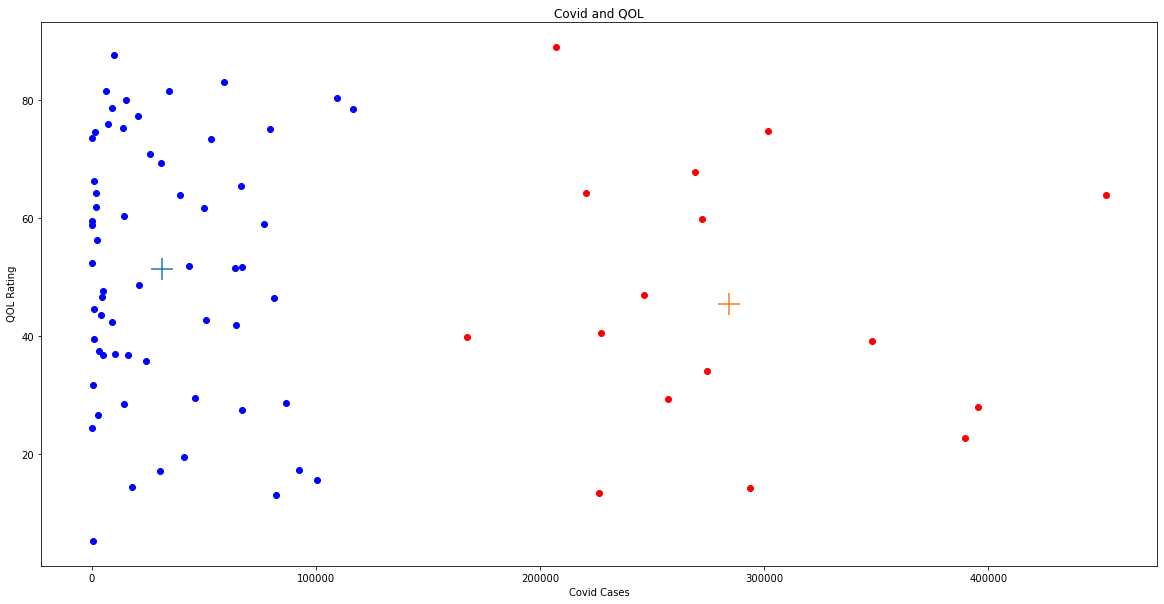

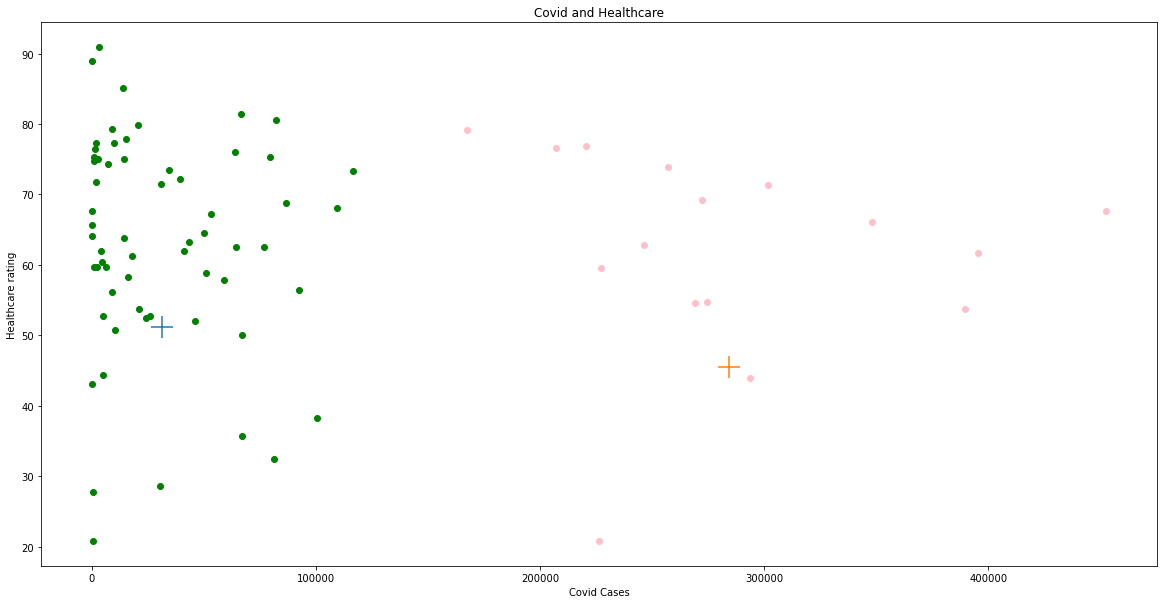

In [123]:
##CLUSTERING COVIDCASES AND HEALTHCARE


# Healthcare
covidAndHealthcare = {}
for cN in country_covid_cases.keys():
    if cN in country_healthcare_rating.keys():
        covidAndHealthcare[cN] = [country_covid_cases[cN],country_healthcare_rating[cN]]

# Pollution
covidAndPollution = {}
for cN in country_covid_cases.keys():
    if cN in country_pollution_rating.keys():
        covidAndPollution[cN] = [country_covid_cases[cN],country_pollution_rating[cN]]

# Quality of Life
covidAndQOL = {}
for cN in country_covid_cases.keys():
    if cN in country_qualityOfLife_rating.keys():
        covidAndQOL[cN] = [country_covid_cases[cN],country_qualityOfLife_rating[cN]]
        
# Healthcare & Pollution
covidAndPollutionAndHealthcare = {}
for cN in country_covid_cases.keys():
    if cN in country_pollution_rating.keys() and cN in country_healthcare_rating.keys():
        covidAndPollutionAndHealthcare[cN] = [country_pollution_rating[cN], country_covid_cases[cN], country_healthcare_rating[cN]]

# Remove outliers from healthcare        
outliers = []
for cN in covidAndHealthcare.keys():
    if covidAndHealthcare[cN][0] > 500000: # Covid Cases over 500,000
        outliers.append(cN)
    elif covidAndHealthcare[cN][1] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    covidAndHealthcare.pop(cN)
    
# Remove outliers from Quality of Life        
outliers = []
for cN in covidAndQOL.keys():
    if covidAndQOL[cN][0] > 500000: # Covid Cases over 500,000
        outliers.append(cN)
    elif covidAndQOL[cN][1] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    covidAndQOL.pop(cN)
    
# Remove outliers from Pollution
outliers = []
for cN in covidAndPollution.keys():
    if covidAndPollution[cN][0] > 500000: # Covid cases over 500,000
        outliers.append(cN)
    elif covidAndPollution[cN][1] < 1: # Countries without pollution reported
        outliers.append(cN)
for cN in outliers:
    covidAndPollution.pop(cN)
    
# Remove outliers from Healthcare & Pollution
outliers = []
for cN in covidAndPollutionAndHealthcare.keys():
    if covidAndPollutionAndHealthcare[cN][1] > 500000: # Covid cases over 500,000
        outliers.append(cN)
    elif covidAndPollutionAndHealthcare[cN][0] < 1: # Countries without pollution reported
        outliers.append(cN)
    elif covidAndPollutionAndHealthcare[cN][2] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    covidAndPollutionAndHealthcare.pop(cN)

# Store values from dictionaries for clustering
X = np.array(list(covidAndHealthcare.values()))
X2 = np.array(list(covidAndPollution.values()))
X3 = np.array(list(covidAndPollutionAndHealthcare.values()))
X4 = np.array(list(covidAndQOL.values()))

#DBSCAN
# clustering = DBSCAN(eps=2, min_samples=2).fit(X)
# clustering = DBSCAN(eps=k, min_samples=2).fit(X)
# clusterLabels = clustering.labels_
# print(clusterLabels)

# kmeans
sse = []
for k in range(1, 11):
    kmeans = KMeans(init="random",n_clusters=k,n_init=10,max_iter=300,random_state=42)
    kmeans.fit(X2)
    sse.append(kmeans.inertia_)
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("kl:",kl.elbow)
    
kmeans = KMeans(init="random",n_clusters=kl.elbow,n_init=10,max_iter=300,random_state=42)
# kmeans.fit(X)
kmeans.fit(X4)
# kmeans.fit(X3)
cluster_centers = kmeans.cluster_centers_

kmeansLabels = kmeans.labels_
print("Converged in:",kmeans.n_iter_,"iterations")


# Assign to clusters
cluster1 = []
cluster2 = []
cluster11 = []
cluster22 = []
# cluster3 = []
# cluster4 = []
# for i in range(len(kmeansLabels)):
#     if kmeansLabels[i] == 0:
#         cluster1.append([X3[i][0],X3[i][1],X3[i][2]])
#     elif kmeansLabels[i] == 1:
#         cluster2.append([X3[i][0],X3[i][1],X3[i][2]])
#     elif kmeansLabels[i] == 2:
#         cluster3.append([X3[i][0],X3[i][1],X3[i][2]])        
#     elif kmeansLabels[i] == 3:
#         cluster4.append([X3[i][0],X3[i][1],X3[i][2]])
for i in range(len(kmeansLabels)):
    if kmeansLabels[i] == 0:
        cluster1.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster11.append([X[i][0],X[i][1]]) #covidAndHealthcare
    elif kmeansLabels[i] == 1:
        cluster2.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster22.append([X[i][0],X[i][1]]) #covidAndHealthcare
    elif kmeansLabels[i] == 2:
        cluster3.append([X4[i][0],X4[i][1]]) 
    elif kmeansLabels[i] == 3:
        cluster4.append([X4[i][0],X4[i][1]])
        
        
        
cluster1 = np.array(cluster1) #covidAndQOL
cluster2 = np.array(cluster2) #covidAndQOL

cluster11 = np.array(cluster11) #covidAndHealthcare
cluster22 = np.array(cluster22) #covidAndHealthcare
# cluster3 = np.array(cluster3)
# cluster4 = np.array(cluster4)

fig, ax = plt.subplots(figsize=(20,10))
for c in cluster_centers: #covidAndQOL
    ax.scatter(c[0],c[1],marker = "+",s=500)
ax.scatter(cluster1[:,0],cluster1[:,1],color="blue")
ax.scatter(cluster2[:,0],cluster2[:,1],color="red")
# ax.scatter(cluster3[:,0],cluster3[:,1],color="green")
# ax.scatter(cluster4[:,0],cluster4[:,1],color="orange")
plt.title("Covid and QOL")
plt.xlabel("Covid Cases")
plt.ylabel(" QOL Rating")

fig, ax = plt.subplots(figsize=(20,10))
for cc in cluster_centers: #covidAndHealthcare
    ax.scatter(cc[0],cc[1],marker = "+",s=500)
ax.scatter(cluster11[:,0],cluster11[:,1],color="green")
ax.scatter(cluster22[:,0],cluster22[:,1],color="pink")
plt.title("Covid and Healthcare")
plt.xlabel("Covid Cases")
plt.ylabel("Healthcare rating")

# # Creating figure
# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")

# # ax.scatter3D(X3[:,0], X3[:,1], X3[:,2], color = "green")
# for c in cluster_centers:
#     ax.scatter(c[0],c[1],c[2],marker = "+",s=500)
# ax.scatter3D(cluster1[:,0],cluster1[:,1],cluster1[:,2],color="blue")
# ax.scatter3D(cluster2[:,0],cluster2[:,1],cluster2[:,2],color="red")
# # ax.scatter3D(cluster3[:,0],cluster3[:,1],cluster3[:,2],color="green")
# # ax.scatter3D(cluster4[:,0],cluster4[:,1],cluster4[:,2],color="orange")
# plt.title("Country Pollution and Healthcare")
plt.show()

In [124]:
#Finding IQR for the following country_covid_deathsper100recovered,covid_deathsper100cases, and covid_deaths

deathsper100recovered =[]
deathsper100cases=[]
deaths=[]



for i in country_covid_deathsper100recovered.keys():
    deathsper100recovered.append(country_covid_deathsper100recovered[i])
for i in country_covid_deathsper100cases.keys():
    deathsper100cases.append(country_covid_deathsper100cases[i])
for i in country_covid_deaths.keys():
    deaths.append(country_covid_deaths[i])
    
q75, q25 = np.percentile(deathsper100recovered, [75 ,25])
iqr = q75 - q25
print((1.5*iqr)+q75)

print(q25-(1.5*iqr))

13.5
-6.5


In [125]:
q75, q25 = np.percentile(deathsper100cases, [75 ,25])
iqr = q75 - q25
print((1.5*iqr)+q75)
print(q25-(1.5*iqr))

7.5
-4.5


In [126]:
q75, q25 = np.percentile(deaths, [75 ,25])
iqr = q75 - q25
print((1.5*iqr)+q75)
print(q25-(1.5*iqr))

1807.25
-1054.75


kl: 3
Converged in: 8 iterations


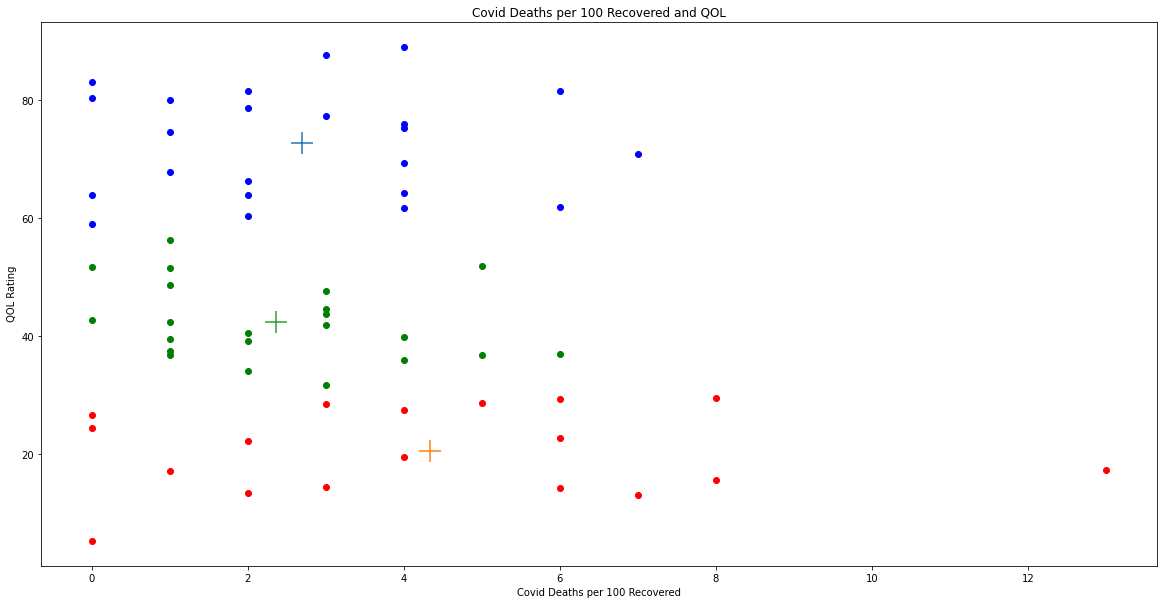

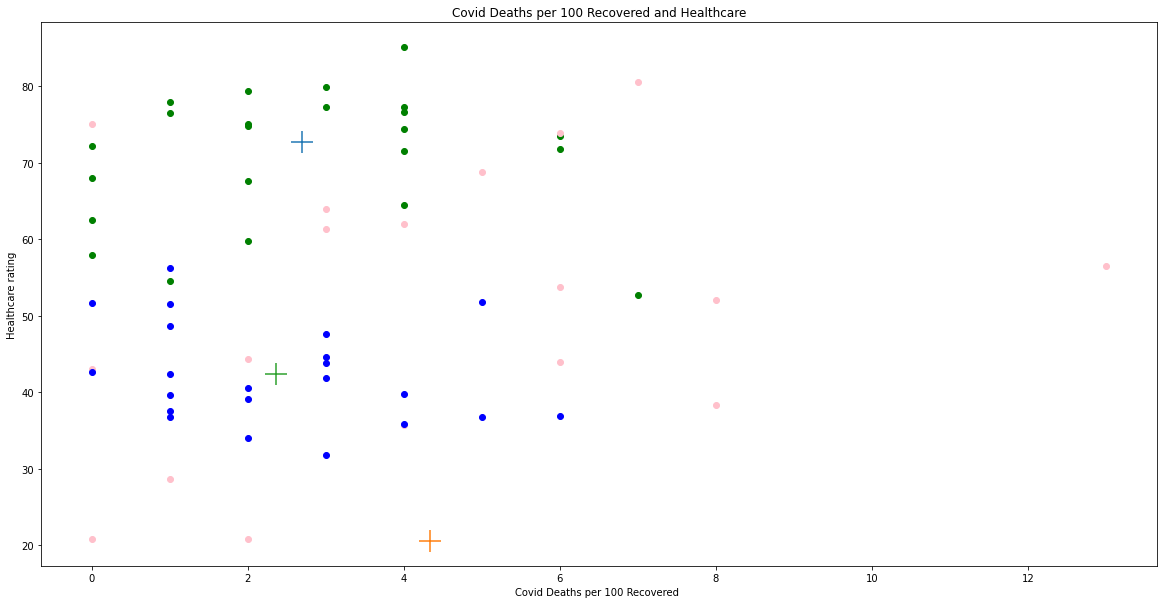

In [127]:
##CLUSTERING country_covid_deathsper100recovered AND HEALTHCARE


# Healthcare
country_covid_deathsper100recoveredAndHealthcare = {}
for cN in country_covid_deathsper100recovered.keys():
    if cN in country_healthcare_rating.keys():
        country_covid_deathsper100recoveredAndHealthcare[cN] = [country_covid_deathsper100recovered[cN],country_healthcare_rating[cN]]

# Pollution
country_covid_deathsper100recoveredAndPollution = {}
for cN in country_covid_deathsper100recovered.keys():
    if cN in country_pollution_rating.keys():
        country_covid_deathsper100recoveredAndPollution[cN] = [country_covid_deathsper100recovered[cN],country_pollution_rating[cN]]

# Quality of Life
country_covid_deathsper100recoveredAndQOL = {}
for cN in country_covid_deathsper100recovered.keys():
    if cN in country_qualityOfLife_rating.keys():
        country_covid_deathsper100recoveredAndQOL[cN] = [country_covid_deathsper100recovered[cN],country_qualityOfLife_rating[cN]]
        
# Healthcare & Pollution
country_covid_deathsper100recoveredAndPollutionAndHealthcare = {}
for cN in country_covid_deathsper100recovered.keys():
    if cN in country_pollution_rating.keys() and cN in country_healthcare_rating.keys():
        country_covid_deathsper100recoveredAndPollutionAndHealthcare[cN] = [country_pollution_rating[cN], country_covid_deathsper100recovered[cN], country_healthcare_rating[cN]]

# Remove outliers from healthcare        
outliers = []
for cN in country_covid_deathsper100recoveredAndHealthcare.keys():
    if country_covid_deathsper100recoveredAndHealthcare[cN][0] > 13.5: # Covid Cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsper100recoveredAndHealthcare[cN][1] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsper100recoveredAndHealthcare.pop(cN)
    
# Remove outliers from Quality of Life        
outliers = []
for cN in country_covid_deathsper100recoveredAndQOL.keys():
    if country_covid_deathsper100recoveredAndQOL[cN][0] > 13.5: # Covid Cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsper100recoveredAndQOL[cN][1] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsper100recoveredAndQOL.pop(cN)
    
# Remove outliers from Pollution
outliers = []
for cN in country_covid_deathsper100recoveredAndPollution.keys():
    if country_covid_deathsper100recoveredAndPollution[cN][0] > 13.5: # Covid cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsper100recoveredAndPollution[cN][1] < 1: # Countries without pollution reported
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsper100recoveredAndPollution.pop(cN)
    
# Remove outliers from Healthcare & Pollution
outliers = []
for cN in country_covid_deathsper100recoveredAndPollutionAndHealthcare.keys():
    if country_covid_deathsper100recoveredAndPollutionAndHealthcare[cN][1] > 13.5: # Covid cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsper100recoveredAndPollutionAndHealthcare[cN][0] < 1: # Countries without pollution reported
        outliers.append(cN)
    elif country_covid_deathsper100recoveredAndPollutionAndHealthcare[cN][2] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsper100recoveredAndPollutionAndHealthcare.pop(cN)

# Store values from dictionaries for clustering
X = np.array(list(country_covid_deathsper100recoveredAndHealthcare.values()))
X2 = np.array(list(country_covid_deathsper100recoveredAndPollution.values()))
X3 = np.array(list(country_covid_deathsper100recoveredAndPollutionAndHealthcare.values()))
X4 = np.array(list(country_covid_deathsper100recoveredAndQOL.values()))

#DBSCAN
# clustering = DBSCAN(eps=2, min_samples=2).fit(X)
# clustering = DBSCAN(eps=k, min_samples=2).fit(X)
# clusterLabels = clustering.labels_
# print(clusterLabels)

# kmeans
sse = []
for k in range(1, 11):
    kmeans = KMeans(init="random",n_clusters=k,n_init=10,max_iter=300,random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("kl:",kl.elbow)
    
kmeans = KMeans(init="random",n_clusters=kl.elbow,n_init=10,max_iter=300,random_state=42)
# kmeans.fit(X)
kmeans.fit(X4)
# kmeans.fit(X3)
cluster_centers = kmeans.cluster_centers_

kmeansLabels = kmeans.labels_
print("Converged in:",kmeans.n_iter_,"iterations")


# Assign to clusters
cluster1 = []
cluster2 = []
cluster11 = []
cluster22 = []
cluster3=[]
cluster33 = []
cluster4 = []
cluster44 = []
# for i in range(len(kmeansLabels)):
#     if kmeansLabels[i] == 0:
#         cluster1.append([X3[i][0],X3[i][1],X3[i][2]])
#     elif kmeansLabels[i] == 1:
#         cluster2.append([X3[i][0],X3[i][1],X3[i][2]])
#     elif kmeansLabels[i] == 2:
#         cluster3.append([X3[i][0],X3[i][1],X3[i][2]])        
#     elif kmeansLabels[i] == 3:
#         cluster4.append([X3[i][0],X3[i][1],X3[i][2]])
for i in range(len(kmeansLabels)):
    if kmeansLabels[i] == 0:
        cluster1.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster11.append([X[i][0],X[i][1]]) #covidAndHealthcare
    elif kmeansLabels[i] == 1:
        cluster2.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster22.append([X[i][0],X[i][1]]) #covidAndHealthcare
    elif kmeansLabels[i] == 2:
        cluster3.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster33.append([X[i][0],X[i][1]]) #covidAndHealthcare 
    elif kmeansLabels[i] == 3:
        cluster4.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster44.append([X[i][0],X[i][1]]) #covidAndHealthcare
        
        
        
cluster1 = np.array(cluster1) #covidAndQOL
cluster2 = np.array(cluster2) #covidAndQOL
cluster3 = np.array(cluster3) #covidAndQOL
cluster4 = np.array(cluster4) #covidAndQOL

cluster11 = np.array(cluster11) #covidAndHealthcare
cluster22 = np.array(cluster22) #covidAndHealthcare
cluster33 = np.array(cluster33)
cluster44 = np.array(cluster44)

fig, ax = plt.subplots(figsize=(20,10))
for c in cluster_centers: #covidAndQOL
    ax.scatter(c[0],c[1],marker = "+",s=500)
ax.scatter(cluster1[:,0],cluster1[:,1],color="blue")
ax.scatter(cluster2[:,0],cluster2[:,1],color="red")
ax.scatter(cluster3[:,0],cluster3[:,1],color="green")
plt.title("Covid Deaths per 100 Recovered and QOL")
plt.xlabel("Covid Deaths per 100 Recovered")
plt.ylabel(" QOL Rating")

fig, ax = plt.subplots(figsize=(20,10))
for cc in cluster_centers: #covidAndHealthcare
    ax.scatter(cc[0],cc[1],marker = "+",s=500)
ax.scatter(cluster11[:,0],cluster11[:,1],color="green")
ax.scatter(cluster22[:,0],cluster22[:,1],color="pink")
ax.scatter(cluster3[:,0],cluster3[:,1],color="blue")
plt.title("Covid Deaths per 100 Recovered and Healthcare")
plt.xlabel("Covid Deaths per 100 Recovered ")
plt.ylabel("Healthcare rating")

# # Creating figure
# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")

# # ax.scatter3D(X3[:,0], X3[:,1], X3[:,2], color = "green")
# for c in cluster_centers:
#     ax.scatter(c[0],c[1],c[2],marker = "+",s=500)
# ax.scatter3D(cluster1[:,0],cluster1[:,1],cluster1[:,2],color="blue")
# ax.scatter3D(cluster2[:,0],cluster2[:,1],cluster2[:,2],color="red")
# # ax.scatter3D(cluster3[:,0],cluster3[:,1],cluster3[:,2],color="green")
# # ax.scatter3D(cluster4[:,0],cluster4[:,1],cluster4[:,2],color="orange")
# plt.title("Country Pollution and Healthcare")
plt.show()

kl: 3
Converged in: 6 iterations


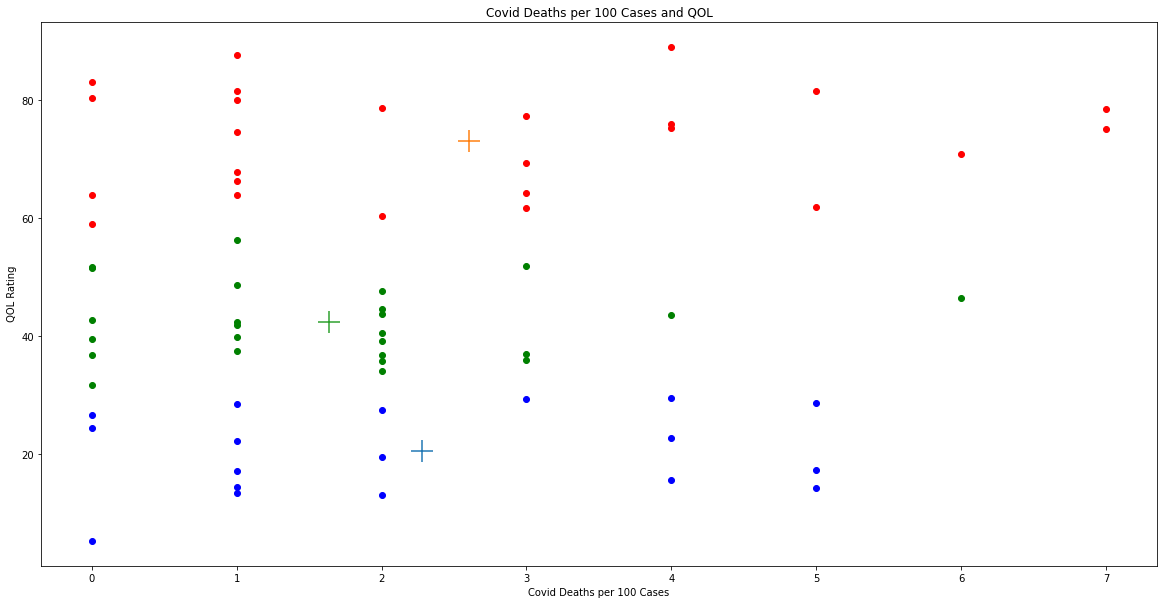

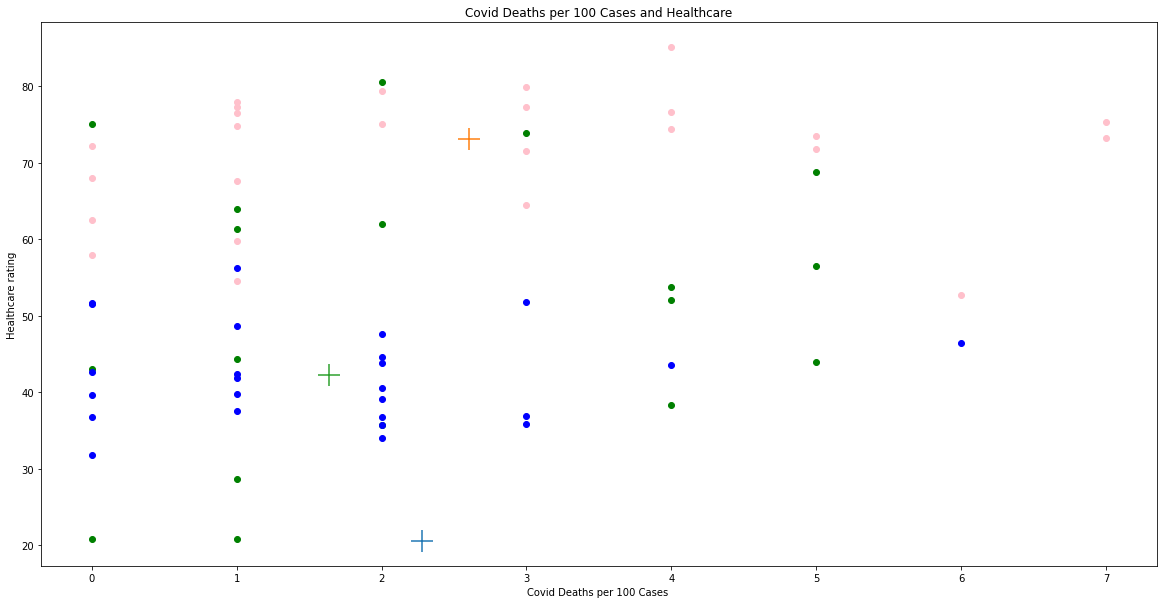

In [133]:
##CLUSTERING country_covid_deathsper100cases AND HEALTHCARE


# Healthcare
country_covid_deathsper100casesAndHealthcare = {}
for cN in country_covid_deathsper100cases.keys():
    if cN in country_healthcare_rating.keys():
        country_covid_deathsper100casesAndHealthcare[cN] = [country_covid_deathsper100cases[cN],country_healthcare_rating[cN]]

# Pollution
country_covid_deathsper100casesAndPollution = {}
for cN in country_covid_deathsper100cases.keys():
    if cN in country_pollution_rating.keys():
        country_covid_deathsper100casesAndPollution[cN] = [country_covid_deathsper100cases[cN],country_pollution_rating[cN]]

# Quality of Life
country_covid_deathsper100casesAndQOL = {}
for cN in country_covid_deathsper100cases.keys():
    if cN in country_qualityOfLife_rating.keys():
        country_covid_deathsper100casesAndQOL[cN] = [country_covid_deathsper100cases[cN],country_qualityOfLife_rating[cN]]
        
# Healthcare & Pollution
country_covid_deathsper100casesAndPollutionAndHealthcare = {}
for cN in country_covid_deathsper100cases.keys():
    if cN in country_pollution_rating.keys() and cN in country_healthcare_rating.keys():
        country_covid_deathsper100casesAndPollutionAndHealthcare[cN] = [country_pollution_rating[cN], country_covid_deathsper100cases[cN], country_healthcare_rating[cN]]

# Remove outliers from healthcare        
outliers = []
for cN in country_covid_deathsper100casesAndHealthcare.keys():
    if country_covid_deathsper100casesAndHealthcare[cN][0] > 7.5: # Covid Cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsper100casesAndHealthcare[cN][1] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsper100casesAndHealthcare.pop(cN)
    
# Remove outliers from Quality of Life        
outliers = []
for cN in country_covid_deathsper100casesAndQOL.keys():
    if country_covid_deathsper100casesAndQOL[cN][0] > 7.5: # Covid Cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsper100casesAndQOL[cN][1] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsper100casesAndQOL.pop(cN)
    
# Remove outliers from Pollution
outliers = []
for cN in country_covid_deathsper100casesAndPollution.keys():
    if country_covid_deathsper100casesAndPollution[cN][0] > 7.5: # Covid cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsper100casesAndPollution[cN][1] < 1: # Countries without pollution reported
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsper100casesAndPollution.pop(cN)
    
# Remove outliers from Healthcare & Pollution
outliers = []
for cN in country_covid_deathsper100casesAndPollutionAndHealthcare.keys():
    if country_covid_deathsper100casesAndPollutionAndHealthcare[cN][1] > 7.5: # Covid cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsper100casesAndPollutionAndHealthcare[cN][0] < 1: # Countries without pollution reported
        outliers.append(cN)
    elif country_covid_deathsper100casesAndPollutionAndHealthcare[cN][2] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsper100casesAndPollutionAndHealthcare.pop(cN)

# Store values from dictionaries for clustering
X = np.array(list(country_covid_deathsper100casesAndHealthcare.values()))
X2 = np.array(list(country_covid_deathsper100casesAndPollution.values()))
X3 = np.array(list(country_covid_deathsper100casesAndPollutionAndHealthcare.values()))
X4 = np.array(list(country_covid_deathsper100casesAndQOL.values()))

#DBSCAN
# clustering = DBSCAN(eps=2, min_samples=2).fit(X)
# clustering = DBSCAN(eps=k, min_samples=2).fit(X)
# clusterLabels = clustering.labels_
# print(clusterLabels)

# kmeans
sse = []
for k in range(1, 11):
    kmeans = KMeans(init="random",n_clusters=k,n_init=10,max_iter=300,random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("kl:",kl.elbow)
    
kmeans = KMeans(init="random",n_clusters=kl.elbow,n_init=10,max_iter=300,random_state=42)
# kmeans.fit(X)
kmeans.fit(X4)
# kmeans.fit(X3)
cluster_centers = kmeans.cluster_centers_

kmeansLabels = kmeans.labels_
print("Converged in:",kmeans.n_iter_,"iterations")


# Assign to clusters
cluster1 = []
cluster2 = []
cluster11 = []
cluster22 = []
cluster3=[]
cluster33 = []
cluster4 = []
cluster44 = []
# for i in range(len(kmeansLabels)):
#     if kmeansLabels[i] == 0:
#         cluster1.append([X3[i][0],X3[i][1],X3[i][2]])
#     elif kmeansLabels[i] == 1:
#         cluster2.append([X3[i][0],X3[i][1],X3[i][2]])
#     elif kmeansLabels[i] == 2:
#         cluster3.append([X3[i][0],X3[i][1],X3[i][2]])        
#     elif kmeansLabels[i] == 3:
#         cluster4.append([X3[i][0],X3[i][1],X3[i][2]])
for i in range(len(kmeansLabels)):
    if kmeansLabels[i] == 0:
        cluster1.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster11.append([X[i][0],X[i][1]]) #covidAndHealthcare
    elif kmeansLabels[i] == 1:
        cluster2.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster22.append([X[i][0],X[i][1]]) #covidAndHealthcare
    elif kmeansLabels[i] == 2:
        cluster3.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster33.append([X[i][0],X[i][1]]) #covidAndHealthcare 
    elif kmeansLabels[i] == 3:
        cluster4.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster44.append([X[i][0],X[i][1]]) #covidAndHealthcare
        
        
        
cluster1 = np.array(cluster1) #covidAndQOL
cluster2 = np.array(cluster2) #covidAndQOL
cluster3 = np.array(cluster3) #covidAndQOL
cluster4 = np.array(cluster4) #covidAndQOL

cluster11 = np.array(cluster11) #covidAndHealthcare
cluster22 = np.array(cluster22) #covidAndHealthcare
cluster33 = np.array(cluster33)
cluster44 = np.array(cluster44)

fig, ax = plt.subplots(figsize=(20,10))
for c in cluster_centers: #covidAndQOL
    ax.scatter(c[0],c[1],marker = "+",s=500)
ax.scatter(cluster1[:,0],cluster1[:,1],color="blue")
ax.scatter(cluster2[:,0],cluster2[:,1],color="red")
ax.scatter(cluster3[:,0],cluster3[:,1],color="green")
plt.title("Covid Deaths per 100 Cases and QOL")
plt.xlabel("Covid Deaths per 100 Cases")
plt.ylabel(" QOL Rating")

fig, ax = plt.subplots(figsize=(20,10))
for cc in cluster_centers: #covidAndHealthcare
    ax.scatter(cc[0],cc[1],marker = "+",s=500)
ax.scatter(cluster11[:,0],cluster11[:,1],color="green")
ax.scatter(cluster22[:,0],cluster22[:,1],color="pink")
ax.scatter(cluster3[:,0],cluster3[:,1],color="blue")
plt.title("Covid Deaths per 100 Cases and Healthcare")
plt.xlabel("Covid Deaths per 100 Cases ")
plt.ylabel("Healthcare rating")


# # Creating figure
# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")

# # ax.scatter3D(X3[:,0], X3[:,1], X3[:,2], color = "green")
# for c in cluster_centers:
#     print(c)
#     ax.scatter(c[0],c[1],c[2],marker = "+",s=500)
# ax.scatter3D(cluster1[:,0],cluster1[:,1],cluster1[:,2],color="blue")
# ax.scatter3D(cluster2[:,0],cluster2[:,1],cluster2[:,2],color="red")
# # ax.scatter3D(cluster3[:,0],cluster3[:,1],cluster3[:,2],color="green")
# # ax.scatter3D(cluster4[:,0],cluster4[:,1],cluster4[:,2],color="orange")
# plt.title("Country Pollution and Healthcare")
plt.show()

kl: 3
Converged in: 5 iterations


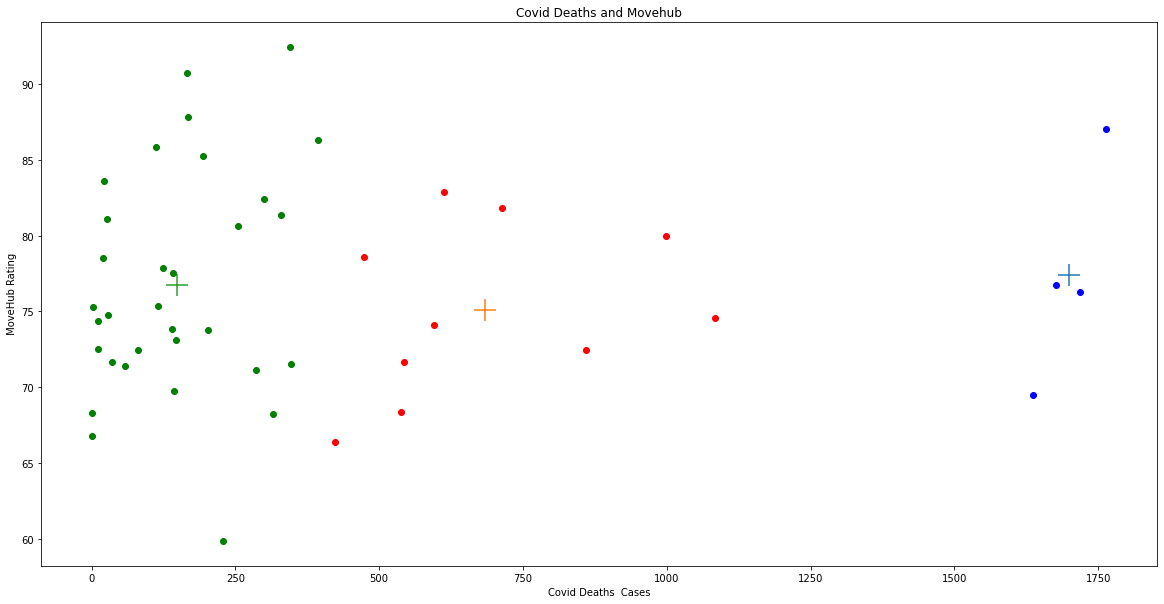

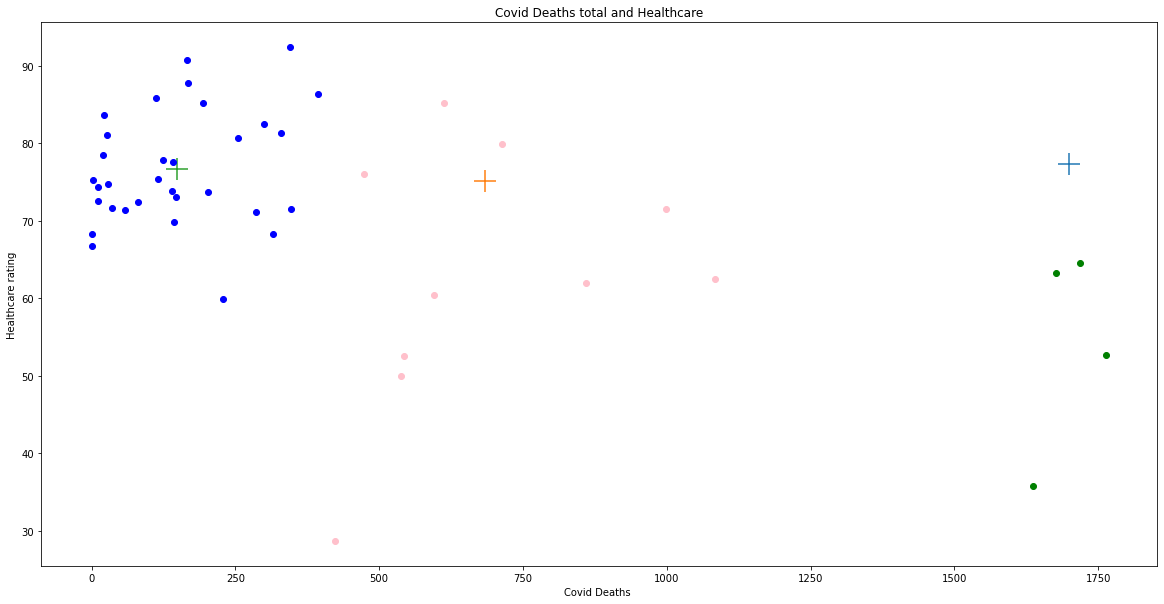

In [132]:
##CLUSTERING country_covid_deaths AND HEALTHCARE


# Healthcare
country_covid_deathsAndHealthcare = {}
for cN in country_covid_deaths.keys():
    if cN in country_healthcare_rating.keys():
        country_covid_deathsAndHealthcare[cN] = [country_covid_deaths[cN],country_healthcare_rating[cN]]

# Pollution
country_covid_deathsAndPollution = {}
for cN in country_covid_deaths.keys():
    if cN in country_pollution_rating.keys():
        country_covid_deathsAndPollution[cN] = [country_covid_deaths[cN],country_pollution_rating[cN]]

# country_Movehub_rating 
country_covid_deathsAndcountry_Movehub_rating  = {}
for cN in country_covid_deaths.keys():
    if cN in country_Movehub_rating .keys():
        country_covid_deathsAndcountry_Movehub_rating [cN] = [country_covid_deaths[cN],country_Movehub_rating [cN]]
        
# Healthcare & Pollution
country_covid_deathsAndPollutionAndHealthcare = {}
for cN in country_covid_deaths.keys():
    if cN in country_pollution_rating.keys() and cN in country_healthcare_rating.keys():
        country_covid_deathsAndPollutionAndHealthcare[cN] = [country_pollution_rating[cN], country_covid_deaths[cN], country_healthcare_rating[cN]]

# Remove outliers from healthcare        
outliers = []
for cN in country_covid_deathsAndHealthcare.keys():
    if country_covid_deathsAndHealthcare[cN][0] > 1800: # Covid Cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsAndHealthcare[cN][1] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsAndHealthcare.pop(cN)
    
# Remove outliers from Quality of Life        
outliers = []
for cN in country_covid_deathsAndcountry_Movehub_rating .keys():
    if country_covid_deathsAndcountry_Movehub_rating [cN][0] > 1800: # Covid Cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsAndcountry_Movehub_rating [cN][1] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsAndcountry_Movehub_rating .pop(cN)
    
# Remove outliers from Pollution
outliers = []
for cN in country_covid_deathsAndPollution.keys():
    if country_covid_deathsAndPollution[cN][0] > 1800: # Covid cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsAndPollution[cN][1] < 1: # Countries without pollution reported
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsAndPollution.pop(cN)
    
# Remove outliers from Healthcare & Pollution
outliers = []
for cN in country_covid_deathsAndPollutionAndHealthcare.keys():
    if country_covid_deathsAndPollutionAndHealthcare[cN][1] > 1800: # Covid cases over 500,000
        outliers.append(cN)
    elif country_covid_deathsAndPollutionAndHealthcare[cN][0] < 1: # Countries without pollution reported
        outliers.append(cN)
    elif country_covid_deathsAndPollutionAndHealthcare[cN][2] < 1: # Countries without healthcare rating
        outliers.append(cN)
for cN in outliers:
    country_covid_deathsAndPollutionAndHealthcare.pop(cN)

# Store values from dictionaries for clustering
X = np.array(list(country_covid_deathsAndHealthcare.values()))
X2 = np.array(list(country_covid_deathsAndPollution.values()))
X3 = np.array(list(country_covid_deathsAndPollutionAndHealthcare.values()))
X4 = np.array(list(country_covid_deathsAndcountry_Movehub_rating .values()))

#DBSCAN
# clustering = DBSCAN(eps=2, min_samples=2).fit(X)
# clustering = DBSCAN(eps=k, min_samples=2).fit(X)
# clusterLabels = clustering.labels_
# print(clusterLabels)

# kmeans
sse = []
for k in range(1, 11):
    kmeans = KMeans(init="random",n_clusters=k,n_init=10,max_iter=300,random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("kl:",kl.elbow)
    
kmeans = KMeans(init="random",n_clusters=kl.elbow,n_init=10,max_iter=300,random_state=42)
# kmeans.fit(X)
kmeans.fit(X4)
# kmeans.fit(X3)
cluster_centers = kmeans.cluster_centers_

kmeansLabels = kmeans.labels_
print("Converged in:",kmeans.n_iter_,"iterations")


# Assign to clusters
cluster1 = []
cluster2 = []
cluster11 = []
cluster22 = []
cluster3=[]
cluster33 = []
cluster4 = []
cluster44 = []
# for i in range(len(kmeansLabels)):
#     if kmeansLabels[i] == 0:
#         cluster1.append([X3[i][0],X3[i][1],X3[i][2]])
#     elif kmeansLabels[i] == 1:
#         cluster2.append([X3[i][0],X3[i][1],X3[i][2]])
#     elif kmeansLabels[i] == 2:
#         cluster3.append([X3[i][0],X3[i][1],X3[i][2]])        
#     elif kmeansLabels[i] == 3:
#         cluster4.append([X3[i][0],X3[i][1],X3[i][2]])
for i in range(len(kmeansLabels)):
    if kmeansLabels[i] == 0:
        cluster1.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster11.append([X[i][0],X[i][1]]) #covidAndHealthcare
    elif kmeansLabels[i] == 1:
        cluster2.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster22.append([X[i][0],X[i][1]]) #covidAndHealthcare
    elif kmeansLabels[i] == 2:
        cluster3.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster33.append([X[i][0],X[i][1]]) #covidAndHealthcare 
    elif kmeansLabels[i] == 3:
        cluster4.append([X4[i][0],X4[i][1]]) #covidAndQOL
        cluster44.append([X[i][0],X[i][1]]) #covidAndHealthcare
        
        
        
cluster1 = np.array(cluster1) #covidAndQOL
cluster2 = np.array(cluster2) #covidAndQOL
cluster3 = np.array(cluster3) #covidAndQOL
cluster4 = np.array(cluster4) #covidAndQOL

cluster11 = np.array(cluster11) #covidAndHealthcare
cluster22 = np.array(cluster22) #covidAndHealthcare
cluster3 = np.array(cluster3)
cluster4 = np.array(cluster4)

fig, ax = plt.subplots(figsize=(20,10))
for c in cluster_centers: #covidAndQOL
    ax.scatter(c[0],c[1],marker = "+",s=500)
ax.scatter(cluster1[:,0],cluster1[:,1],color="blue")
ax.scatter(cluster2[:,0],cluster2[:,1],color="red")
ax.scatter(cluster3[:,0],cluster3[:,1],color="green")
plt.title("Covid Deaths and Movehub")
plt.xlabel("Covid Deaths  Cases")
plt.ylabel(" MoveHub Rating")

fig, ax = plt.subplots(figsize=(20,10))
for cc in cluster_centers: #covidAndHealthcare
    ax.scatter(cc[0],cc[1],marker = "+",s=500)
ax.scatter(cluster11[:,0],cluster11[:,1],color="green")
ax.scatter(cluster22[:,0],cluster22[:,1],color="pink")
ax.scatter(cluster3[:,0],cluster3[:,1],color="blue")
plt.title("Covid Deaths total and Healthcare")
plt.xlabel("Covid Deaths ")
plt.ylabel("Healthcare rating")


# # Creating figure
# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")

# # ax.scatter3D(X3[:,0], X3[:,1], X3[:,2], color = "green")
# for c in cluster_centers:
#     ax.scatter(c[0],c[1],c[2],marker = "+",s=500)
# ax.scatter3D(cluster1[:,0],cluster1[:,1],cluster1[:,2],color="blue")
# ax.scatter3D(cluster2[:,0],cluster2[:,1],cluster2[:,2],color="red")
# # ax.scatter3D(cluster3[:,0],cluster3[:,1],cluster3[:,2],color="green")
# # ax.scatter3D(cluster4[:,0],cluster4[:,1],cluster4[:,2],color="orange")
# plt.title("Country Pollution and Healthcare")
plt.show()

In [ ]:
|